## Predicting the Diesel Purchase at certain period within Nairobi

In this notebook we are going to go work towards predicting the purchase of Diesel fuel within Nairobi.
We will follow the below steps:

### 1. Problem Definition

> How well can we predict the purchase of Diesel product by fuel card clients within Nairobi given the details of previous Diesel purchases by those clients between the years 2018 and 2020?

### 2. Data

The data is from the card department.
It will be split into training and testing datasets.


### 3. Features

The features are provided with the dataset.

### 4. Modelling

Choosing the model that is best for achieving wanted results.

### 5. Evaluation

The evaluation metric is the RMSLE (root mean squared log error), mean absolute error and r- squared score between the actual and predicted quantity of Diesel purchased.

**Note:** The goal for most regression evaluation metrics is to minimize the error.

### 6. Experiments

Performing some hyperparameter tuning of the model to see whether we can improve model performance.

### Importing Required Libraries

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium

# Models from scikit learn
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

# Model Evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import plot_roc_curve

## 2. Data

#### Parsing Dates

When working with time series data, we want to enrich the time and date component as much as possible.

We do that by telling pandas which of our columns ha dates in it using the `parse_dates` parameter.

In [17]:
diesel_df = pd.read_csv('diesel_analysis.csv', low_memory = False, parse_dates = ['Transaction date'])

In [3]:
diesel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182679 entries, 0 to 1182678
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Unnamed: 0            1182679 non-null  int64         
 1   PetrolPlus Client ID  1182679 non-null  int64         
 2   Client Name           1182679 non-null  object        
 3   Transaction date      1182679 non-null  datetime64[ns]
 4   POS ID                1182679 non-null  int64         
 5   Service Station       1182679 non-null  object        
 6   Card No. or Ref. No.  1182679 non-null  int64         
 7   Operation             1182679 non-null  object        
 8   Product/Service       1182679 non-null  object        
 9   Quantity              1182679 non-null  float64       
 10  Terminal price        1182679 non-null  float64       
 11  Customer Price        1182679 non-null  float64       
 12  Customer Amount       1182679 non-null  fl

## Preparing the data

In [4]:
diesel_df.columns

Index(['Unnamed: 0', 'PetrolPlus Client ID', 'Client Name', 'Transaction date',
       'POS ID', 'Service Station', 'Card No. or Ref. No.', 'Operation',
       'Product/Service', 'Quantity', 'Terminal price', 'Customer Price',
       'Customer Amount', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [3]:
# Droping unnecessary column
diesel_df.drop('Unnamed: 0',axis=1,inplace = True)

In [6]:
diesel_df.head(5)

,PetrolPlus Client ID,Client Name,Transaction date,POS ID,Service Station,Card No. or Ref. No.,Operation,Product/Service,Quantity,Terminal price,Customer Price,Customer Amount,Year,Month,Day,Hour
0,2,Client 1,2018-01-02 19:58:32,43,Station 1,1408006788,Serv.,FS Diesel,-53.63,92.4,92.4,-4955.00,2018,1,Tuesday,19
1,2,Client 1,2018-01-04 15:13:54,43,Station 1,1408006788,Serv.,FS Diesel,-36.96,92.4,92.4,-3415.00,2018,1,Thursday,15
2,2,Client 1,2018-01-05 16:45:01,126,Station 2,1408006788,Serv.,FS Diesel,-45.35,92.4,92.4,-4190.00,2018,1,Friday,16
3,2,Client 1,2018-01-12 10:39:37,43,Station 1,1408006788,Serv.,FS Diesel,-50.41,92.4,92.4,-4658.21,2018,1,Friday,10
4,2,Client 1,2018-01-12 16:42:43,126,Station 2,1408006788,Serv.,FS Diesel,-42.21,92.4,92.4,-3900.00,2018,1,Friday,16


In [4]:
# Converting the Quantity and Customer Amount value into positive values
diesel_df['Quantity'] = diesel_df['Quantity'] * -1
diesel_df['Customer Amount'] = diesel_df['Customer Amount'] * -1

In [5]:
diesel_df.tail()

,PetrolPlus Client ID,Client Name,Transaction date,POS ID,Service Station,Card No. or Ref. No.,Operation,Product/Service,Quantity,Terminal price,Customer Price,Customer Amount,Year,Month,Day,Hour
1182674,4853,Client 2963,2020-12-22 14:07:10,8,Station 10,1408040050,Serv.,FS Diesel,43.57,91.8,91.8,4000.0,2020,12,Tuesday,14
1182675,4853,Client 2963,2020-12-24 15:43:25,98,Station 46,1408040050,Serv.,FS Diesel,54.47,91.8,91.8,5000.0,2020,12,Thursday,15
1182676,4853,Client 2963,2020-12-27 18:01:00,97,Station 54,1408040050,Serv.,FS Diesel,43.57,91.8,91.8,4000.0,2020,12,Sunday,18
1182677,4853,Client 2963,2020-12-31 08:04:47,102,Station 61,1408040050,Serv.,FS Diesel,54.47,91.8,91.8,5000.0,2020,12,Thursday,8
1182678,4854,Client 2964,2020-12-30 13:47:06,16,Station 133,1408040112,Serv.,FS Diesel,108.93,91.8,91.8,10000.0,2020,12,Wednesday,13


In [9]:
# Description of the Data frame
diesel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182679 entries, 0 to 1182678
Data columns (total 16 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   PetrolPlus Client ID  1182679 non-null  int64         
 1   Client Name           1182679 non-null  object        
 2   Transaction date      1182679 non-null  datetime64[ns]
 3   POS ID                1182679 non-null  int64         
 4   Service Station       1182679 non-null  object        
 5   Card No. or Ref. No.  1182679 non-null  int64         
 6   Operation             1182679 non-null  object        
 7   Product/Service       1182679 non-null  object        
 8   Quantity              1182679 non-null  float64       
 9   Terminal price        1182679 non-null  float64       
 10  Customer Price        1182679 non-null  float64       
 11  Customer Amount       1182679 non-null  float64       
 12  Year                  1182679 non-null  in

In [10]:
diesel_df['Customer Amount'].sum()

23372953637.879993

In [11]:
diesel_df[['Service Station','Customer Amount']]

,Service Station,Customer Amount
0,Station 1,4955.00
1,Station 1,3415.00
2,Station 2,4190.00
3,Station 1,4658.21
4,Station 2,3900.00
...,...,...
1182674,Station 10,4000.00
1182675,Station 46,5000.00
1182676,Station 54,4000.00
1182677,Station 61,5000.00


In [6]:
# Reading a csv file with more client details
client = pd.read_csv('Card_clients.csv')
client

,Client ID,Client Name,Customer Type
0,2,Client 1,POSTPAID
1,3,Client 2,POSTPAID
2,4,Client 3,POSTPAID
3,5,Client 4,POSTPAID
4,6,Client 5,POSTPAID
...,...,...,...
3108,4999,Client 3109,PREPAID
3109,5000,Client 3110,PREPAID
3110,5001,Client 3111,PREPAID
3111,5002,Client 3112,PREPAID


In [7]:
# Merging the client dataframe with the diesel dataframe
diesel = pd.merge(diesel_df,client,on = 'Client Name',how='inner')
diesel

,PetrolPlus Client ID,Client Name,Transaction date,POS ID,Service Station,Card No. or Ref. No.,Operation,Product/Service,Quantity,Terminal price,Customer Price,Customer Amount,Year,Month,Day,Hour,Client ID,Customer Type
0,2,Client 1,2018-01-02 19:58:32,43,Station 1,1408006788,Serv.,FS Diesel,53.63,92.4,92.4,4955.00,2018,1,Tuesday,19,2,POSTPAID
1,2,Client 1,2018-01-04 15:13:54,43,Station 1,1408006788,Serv.,FS Diesel,36.96,92.4,92.4,3415.00,2018,1,Thursday,15,2,POSTPAID
2,2,Client 1,2018-01-05 16:45:01,126,Station 2,1408006788,Serv.,FS Diesel,45.35,92.4,92.4,4190.00,2018,1,Friday,16,2,POSTPAID
3,2,Client 1,2018-01-12 10:39:37,43,Station 1,1408006788,Serv.,FS Diesel,50.41,92.4,92.4,4658.21,2018,1,Friday,10,2,POSTPAID
4,2,Client 1,2018-01-12 16:42:43,126,Station 2,1408006788,Serv.,FS Diesel,42.21,92.4,92.4,3900.00,2018,1,Friday,16,2,POSTPAID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182674,4853,Client 2963,2020-12-22 14:07:10,8,Station 10,1408040050,Serv.,FS Diesel,43.57,91.8,91.8,4000.00,2020,12,Tuesday,14,4853,POSTPAID
1182675,4853,Client 2963,2020-12-24 15:43:25,98,Station 46,1408040050,Serv.,FS Diesel,54.47,91.8,91.8,5000.00,2020,12,Thursday,15,4853,POSTPAID
1182676,4853,Client 2963,2020-12-27 18:01:00,97,Station 54,1408040050,Serv.,FS Diesel,43.57,91.8,91.8,4000.00,2020,12,Sunday,18,4853,POSTPAID
1182677,4853,Client 2963,2020-12-31 08:04:47,102,Station 61,1408040050,Serv.,FS Diesel,54.47,91.8,91.8,5000.00,2020,12,Thursday,8,4853,POSTPAID


In [8]:
# Loading a csv file with more info on the stations
station = pd.read_csv('Stations.csv')
station

,POS ID,Service Station,County,Lat,Long
0,43,Station 1,Kiambu,-1.160360,36.958071
1,126,Station 2,Kiambu,-1.156237,36.958001
2,91,Station 3,Nairobi,-1.148857,36.922467
3,3,Station 4,Nairobi,-1.321125,36.841660
4,81,Station 5,Nairobi,-1.269104,36.820206
...,...,...,...,...,...
243,251,Station 244,Nairobi,-1.265830,36.988110
244,253,Station 245,Nairobi,-1.281577,36.962088
245,252,Station 246,Nairobi,-1.425384,36.958981
246,254,Station 247,Kiambu,-1.094409,37.026713


In [9]:
# Merging the station dataframe with the diesel dataframe
diesel_df = pd.merge(diesel,station,on='Service Station',how = 'inner')

In [10]:
diesel_df

,PetrolPlus Client ID,Client Name,Transaction date,POS ID_x,Service Station,Card No. or Ref. No.,Operation,Product/Service,Quantity,Terminal price,...,Year,Month,Day,Hour,Client ID,Customer Type,POS ID_y,County,Lat,Long
0,2,Client 1,2018-01-02 19:58:32,43,Station 1,1408006788,Serv.,FS Diesel,53.63,92.4,...,2018,1,Tuesday,19,2,POSTPAID,43,Kiambu,-1.160360,36.958071
1,2,Client 1,2018-01-04 15:13:54,43,Station 1,1408006788,Serv.,FS Diesel,36.96,92.4,...,2018,1,Thursday,15,2,POSTPAID,43,Kiambu,-1.160360,36.958071
2,2,Client 1,2018-01-12 10:39:37,43,Station 1,1408006788,Serv.,FS Diesel,50.41,92.4,...,2018,1,Friday,10,2,POSTPAID,43,Kiambu,-1.160360,36.958071
3,2,Client 1,2018-01-18 08:12:15,43,Station 1,1408006788,Serv.,FS Diesel,63.92,94.8,...,2018,1,Thursday,8,2,POSTPAID,43,Kiambu,-1.160360,36.958071
4,2,Client 1,2018-01-23 10:23:58,43,Station 1,1408006788,Serv.,FS Diesel,45.15,94.8,...,2018,1,Tuesday,10,2,POSTPAID,43,Kiambu,-1.160360,36.958071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182674,3553,Client 1946,2020-12-19 14:29:47,226,Station 220,1408034705,Serv.,FS Diesel,43.57,91.8,...,2020,12,Saturday,14,3553,PREPAID,226,Nairobi,-1.271360,36.852540
1182675,4646,Client 2756,2020-11-24 17:32:45,226,Station 220,1408036925,Serv.,FS Diesel,27.75,90.7,...,2020,11,Tuesday,17,4646,POSTPAID,226,Nairobi,-1.271360,36.852540
1182676,647,Client 236,2020-04-30 15:15:35,999,Station 196,1408023579,Serv.,FS Diesel,29.74,97.5,...,2020,4,Thursday,15,647,POSTPAID,999,Nairobi,-1.286073,36.808279
1182677,3547,Client 1942,2018-07-17 10:50:03,999,Station 196,1408019365,Serv.,FS Diesel,0.01,103.2,...,2018,7,Tuesday,10,3547,PREPAID,999,Nairobi,-1.286073,36.808279


In [17]:
diesel_df.columns

Index(['PetrolPlus Client ID', 'Client Name', 'Transaction date', 'POS ID_x',
       'Service Station', 'Card No. or Ref. No.', 'Operation',
       'Product/Service', 'Quantity', 'Terminal price', 'Customer Price',
       'Customer Amount', 'Year', 'Month', 'Day', 'Hour', 'Client ID',
       'Customer Type', 'POS ID_y', 'County', 'Lat', 'Long'],
      dtype='object')

In [11]:
# Droping unnecessary columns
diesel_df.drop(['PetrolPlus Client ID','POS ID_y','Operation','Customer Price','Customer Amount'],axis=1,inplace = True)

In [12]:
diesel_df.columns

Index(['Client Name', 'Transaction date', 'POS ID_x', 'Service Station',
       'Card No. or Ref. No.', 'Product/Service', 'Quantity', 'Terminal price',
       'Year', 'Month', 'Day', 'Hour', 'Client ID', 'Customer Type', 'County',
       'Lat', 'Long'],
      dtype='object')

In [13]:
# Rearranging the dataframe columns
diesel_df = diesel_df[['Client ID','Client Name', 'Customer Type','Transaction date', 'POS ID_x',
       'Service Station', 'Card No. or Ref. No.',
       'Product/Service', 'Quantity', 'Terminal price', 'Year', 'Month', 'Day', 'Hour', 'County', 'Lat', 'Long']]

In [14]:
diesel_df = diesel_df.rename(columns = {'Card No. or Ref. No.':'Card no.','Product/Service':'Product'})

In [18]:
diesel_df.columns

Index(['Unnamed: 0', 'PetrolPlus Client ID', 'Client Name', 'Transaction date',
       'POS ID', 'Service Station', 'Card No. or Ref. No.', 'Operation',
       'Product/Service', 'Quantity', 'Terminal price', 'Customer Price',
       'Customer Amount', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [15]:
# Filtering out stations within Nairobi
diesel_nbi = diesel_df[diesel_df['County']=='Nairobi']
diesel_nbi

,Client ID,Client Name,Customer Type,Transaction date,POS ID_x,Service Station,Card no.,Product,Quantity,Terminal price,Year,Month,Day,Hour,County,Lat,Long
7597,2,Client 1,POSTPAID,2018-01-19 19:18:12,91,Station 3,1408006788,FS Diesel,44.20,94.8,2018,1,Friday,19,Nairobi,-1.148857,36.922467
7598,2,Client 1,POSTPAID,2018-05-03 18:52:50,91,Station 3,1408006788,FS Diesel,54.19,97.8,2018,5,Thursday,18,Nairobi,-1.148857,36.922467
7599,2,Client 1,POSTPAID,2018-05-11 08:51:10,91,Station 3,1408006788,FS Diesel,56.44,97.8,2018,5,Friday,8,Nairobi,-1.148857,36.922467
7600,2,Client 1,POSTPAID,2018-10-26 13:38:31,91,Station 3,1408020859,FS Diesel,91.16,109.7,2018,10,Friday,13,Nairobi,-1.148857,36.922467
7601,2,Client 1,POSTPAID,2018-11-01 11:00:44,91,Station 3,1408020859,FS Diesel,72.93,109.7,2018,11,Thursday,11,Nairobi,-1.148857,36.922467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182674,3553,Client 1946,PREPAID,2020-12-19 14:29:47,226,Station 220,1408034705,FS Diesel,43.57,91.8,2020,12,Saturday,14,Nairobi,-1.271360,36.852540
1182675,4646,Client 2756,POSTPAID,2020-11-24 17:32:45,226,Station 220,1408036925,FS Diesel,27.75,90.7,2020,11,Tuesday,17,Nairobi,-1.271360,36.852540
1182676,647,Client 236,POSTPAID,2020-04-30 15:15:35,999,Station 196,1408023579,FS Diesel,29.74,97.5,2020,4,Thursday,15,Nairobi,-1.286073,36.808279
1182677,3547,Client 1942,PREPAID,2018-07-17 10:50:03,999,Station 196,1408019365,FS Diesel,0.01,103.2,2018,7,Tuesday,10,Nairobi,-1.286073,36.808279


## Exploratory Data Analysis

In [24]:
# Total quantity purchased within Nairobi from 2018 to 2020 
diesel_nbi['Quantity'].sum()

90781192.21000001

In [16]:
# Descriptive analysis of the diesel_nbi dataframe
diesel_nbi.describe()

,Client ID,POS ID_x,Card no.,Quantity,Terminal price,Year,Month,Hour,Lat,Long
count,488887.000000,488887.000000,4.888870e+05,488887.000000,488887.000000,488887.000000,488887.000000,488887.000000,488887.000000,488887.000000
mean,2198.734331,74.905418,1.408019e+09,185.689520,99.526021,2018.965573,6.511466,12.234441,-1.312260,36.856433
std,1325.231226,65.524125,1.007388e+04,1037.163538,7.748308,0.823038,3.482160,4.223581,0.313703,0.327465
min,2.000000,1.000000,1.408000e+09,0.010000,65.700000,2015.000000,1.000000,0.000000,-4.041039,36.523364
25%,1279.000000,12.000000,1.408010e+09,37.000000,95.000000,2018.000000,3.000000,9.000000,-1.306244,36.799693
50%,2177.000000,83.000000,1.408020e+09,57.460000,101.700000,2019.000000,7.000000,12.000000,-1.288155,36.828097
75%,3088.000000,101.000000,1.408026e+09,85.820000,103.800000,2020.000000,10.000000,15.000000,-1.254860,36.861461
max,4854.000000,999.000000,1.408040e+09,76628.350000,116.300000,2021.000000,12.000000,23.000000,-0.878036,39.657010


In [ ]:
# latitude and longitude values of Kenya
latitude = -0.0236
longitude = 37.9062

# Instantiate a feature group for the location of stations in nairobi
nbi_stations = folium.map.FeatureGroup()

# creating map of kenya
kenya_map = folium.Map(location = [latitude,longitude], zoom_start = 7)

# loop through the conflicts locations and add each to the map
for lat,lng,label in zip (diesel_nbi.Lat,diesel_nbi.Long,diesel_nbi.Quantity):
    nbi_stations.add_child(
        folium.features.CircleMarker(
            [lat,lng],
            radius = 5,
            color = 'yellow',
            popup = label,
            tooltip = 'Click for more information',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.6
        )
    )

kenya_map.add_child(nbi_stations)

In [ ]:
diesel_nbi.info()

In [ ]:
diesel_nbi['Transaction date'].dtype

In [ ]:
# Comparison of Terminal Price and Quantity
#pd.crosstab(diesel_nbi['Terminal price'],diesel_nbi.Quantity).plot(kind='bar',figsize=(20,6))
#plt.title('Quantity of Diesel PUrchased vs Terminal Price')
#plt.xlabel('Terminal Price')
#plt.ylabel('Quantity of Diesel Purchased')

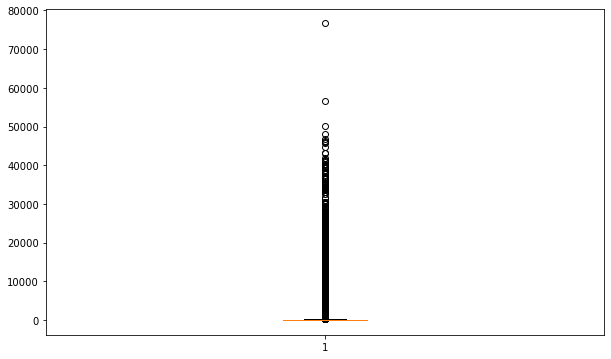

In [22]:
fig, ax = plt.subplots(figsize = (10,6))
ax.boxplot(diesel_nbi['Quantity']);

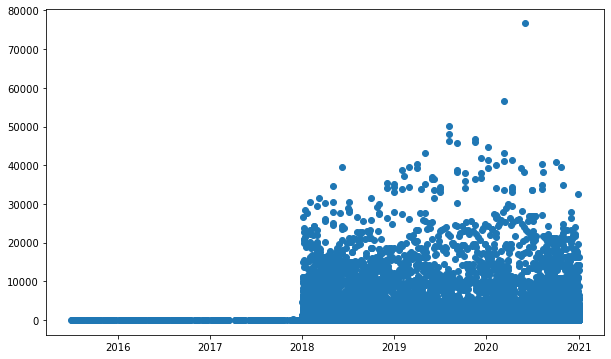

In [17]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(diesel_nbi['Transaction date'],diesel_nbi['Quantity']);

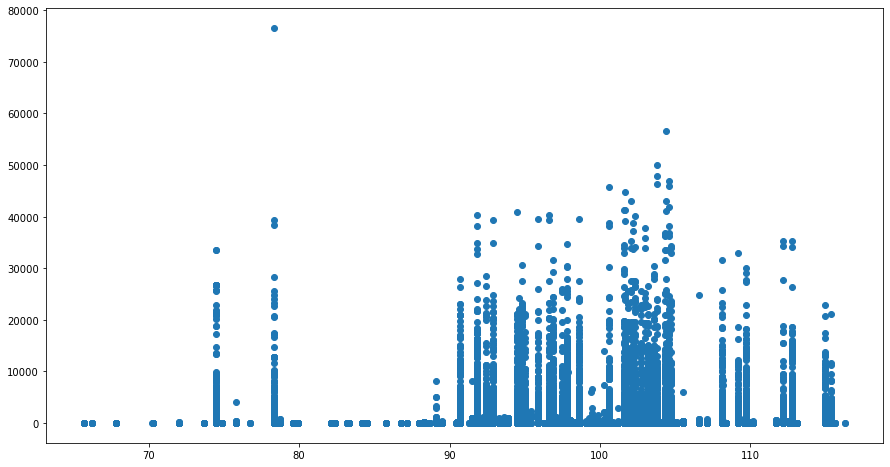

In [18]:
fig, ax = plt.subplots(figsize = (15,8))
ax.scatter(diesel_nbi['Terminal price'],diesel_nbi['Quantity']);

In [26]:
# Viewing all columns of the DataFrame
diesel_nbi.head().T

,7597,7598,7599,7600,7601
Client ID,2,2,2,2,2
Client Name,Client 1,Client 1,Client 1,Client 1,Client 1
Customer Type,POSTPAID,POSTPAID,POSTPAID,POSTPAID,POSTPAID
Transaction date,2018-01-19 19:18:12,2018-05-03 18:52:50,2018-05-11 08:51:10,2018-10-26 13:38:31,2018-11-01 11:00:44
POS ID_x,91,91,91,91,91
Service Station,Station 3,Station 3,Station 3,Station 3,Station 3
Card no.,1408006788,1408006788,1408006788,1408020859,1408020859
Product,FS Diesel,FS Diesel,FS Diesel,FS Diesel,FS Diesel
Quantity,44.2,54.19,56.44,91.16,72.93
Terminal price,94.8,97.8,97.8,109.7,109.7


In [ ]:
# Sort Dataframe by date order
diesel_nbi.sort_values(by=diesel_nbi['Transaction date'], inplace = True, ascending = True)

In [19]:
diesel_nbi.head()

,Client ID,Client Name,Customer Type,Transaction date,POS ID_x,Service Station,Card no.,Product,Quantity,Terminal price,Year,Month,Day,Hour,County,Lat,Long
7597,2,Client 1,POSTPAID,2018-01-19 19:18:12,91,Station 3,1408006788,FS Diesel,44.20,94.8,2018,1,Friday,19,Nairobi,-1.148857,36.922467
7598,2,Client 1,POSTPAID,2018-05-03 18:52:50,91,Station 3,1408006788,FS Diesel,54.19,97.8,2018,5,Thursday,18,Nairobi,-1.148857,36.922467
7599,2,Client 1,POSTPAID,2018-05-11 08:51:10,91,Station 3,1408006788,FS Diesel,56.44,97.8,2018,5,Friday,8,Nairobi,-1.148857,36.922467
7600,2,Client 1,POSTPAID,2018-10-26 13:38:31,91,Station 3,1408020859,FS Diesel,91.16,109.7,2018,10,Friday,13,Nairobi,-1.148857,36.922467
7601,2,Client 1,POSTPAID,2018-11-01 11:00:44,91,Station 3,1408020859,FS Diesel,72.93,109.7,2018,11,Thursday,11,Nairobi,-1.148857,36.922467


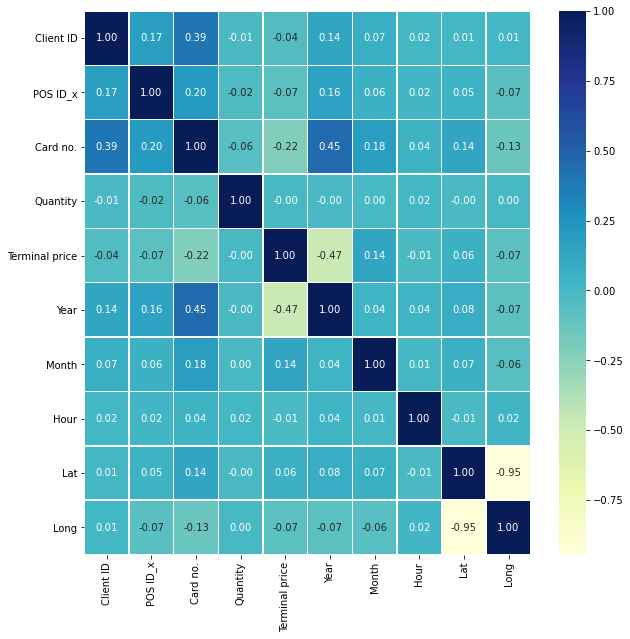

In [21]:
# Correlation Matrix using seaborn heatmap
corr_matrix = diesel_nbi.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr_matrix, annot = True,linewidths = 0.5, fmt = '.2f', cmap = 'YlGnBu')

### Make a copy of the original DataFrame

In [40]:
df_nbi = diesel_nbi.copy()
df_nbi

,Client ID,Client Name,Customer Type,Transaction date,POS ID_x,Service Station,Card no.,Product,Quantity,Terminal price,Year,Month,Day,Hour,County,Lat,Long
7597,2,Client 1,POSTPAID,2018-01-19 19:18:12,91,Station 3,1408006788,FS Diesel,44.20,94.8,2018,1,Friday,19,Nairobi,-1.148857,36.922467
7598,2,Client 1,POSTPAID,2018-05-03 18:52:50,91,Station 3,1408006788,FS Diesel,54.19,97.8,2018,5,Thursday,18,Nairobi,-1.148857,36.922467
7599,2,Client 1,POSTPAID,2018-05-11 08:51:10,91,Station 3,1408006788,FS Diesel,56.44,97.8,2018,5,Friday,8,Nairobi,-1.148857,36.922467
7600,2,Client 1,POSTPAID,2018-10-26 13:38:31,91,Station 3,1408020859,FS Diesel,91.16,109.7,2018,10,Friday,13,Nairobi,-1.148857,36.922467
7601,2,Client 1,POSTPAID,2018-11-01 11:00:44,91,Station 3,1408020859,FS Diesel,72.93,109.7,2018,11,Thursday,11,Nairobi,-1.148857,36.922467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182674,3553,Client 1946,PREPAID,2020-12-19 14:29:47,226,Station 220,1408034705,FS Diesel,43.57,91.8,2020,12,Saturday,14,Nairobi,-1.271360,36.852540
1182675,4646,Client 2756,POSTPAID,2020-11-24 17:32:45,226,Station 220,1408036925,FS Diesel,27.75,90.7,2020,11,Tuesday,17,Nairobi,-1.271360,36.852540
1182676,647,Client 236,POSTPAID,2020-04-30 15:15:35,999,Station 196,1408023579,FS Diesel,29.74,97.5,2020,4,Thursday,15,Nairobi,-1.286073,36.808279
1182677,3547,Client 1942,PREPAID,2018-07-17 10:50:03,999,Station 196,1408019365,FS Diesel,0.01,103.2,2018,7,Tuesday,10,Nairobi,-1.286073,36.808279


## 3. Features

### Feature Engineering

In [41]:
# Adding columns to the dataframe
df_nbi['Quarter'] = df_nbi['Transaction date'].dt.quarter
df_nbi['DayOfWeek'] = df_nbi['Transaction date'].dt.dayofweek
df_nbi['DayOfYear'] = df_nbi['Transaction date'].dt.dayofyear
df_nbi[['Transaction date','Quarter','DayOfWeek','DayOfYear']]

,Transaction date,Quarter,DayOfWeek,DayOfYear
7597,2018-01-19 19:18:12,1,4,19
7598,2018-05-03 18:52:50,2,3,123
7599,2018-05-11 08:51:10,2,4,131
7600,2018-10-26 13:38:31,4,4,299
7601,2018-11-01 11:00:44,4,3,305
...,...,...,...,...
1182674,2020-12-19 14:29:47,4,5,354
1182675,2020-11-24 17:32:45,4,1,329
1182676,2020-04-30 15:15:35,2,3,121
1182677,2018-07-17 10:50:03,3,1,198


In [ ]:
df_nbi.head().T

In [42]:
# Having enriched the dataframe with datetime features we can drop the Transaction date column
df_nbi.drop(['Transaction date'], axis = 1, inplace = True)

In [43]:
df_nbi.drop(['County'], axis = 1, inplace = True)
df_nbi

,Client ID,Client Name,Customer Type,POS ID_x,Service Station,Card no.,Product,Quantity,Terminal price,Year,Month,Day,Hour,Lat,Long,Quarter,DayOfWeek,DayOfYear
7597,2,Client 1,POSTPAID,91,Station 3,1408006788,FS Diesel,44.20,94.8,2018,1,Friday,19,-1.148857,36.922467,1,4,19
7598,2,Client 1,POSTPAID,91,Station 3,1408006788,FS Diesel,54.19,97.8,2018,5,Thursday,18,-1.148857,36.922467,2,3,123
7599,2,Client 1,POSTPAID,91,Station 3,1408006788,FS Diesel,56.44,97.8,2018,5,Friday,8,-1.148857,36.922467,2,4,131
7600,2,Client 1,POSTPAID,91,Station 3,1408020859,FS Diesel,91.16,109.7,2018,10,Friday,13,-1.148857,36.922467,4,4,299
7601,2,Client 1,POSTPAID,91,Station 3,1408020859,FS Diesel,72.93,109.7,2018,11,Thursday,11,-1.148857,36.922467,4,3,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182674,3553,Client 1946,PREPAID,226,Station 220,1408034705,FS Diesel,43.57,91.8,2020,12,Saturday,14,-1.271360,36.852540,4,5,354
1182675,4646,Client 2756,POSTPAID,226,Station 220,1408036925,FS Diesel,27.75,90.7,2020,11,Tuesday,17,-1.271360,36.852540,4,1,329
1182676,647,Client 236,POSTPAID,999,Station 196,1408023579,FS Diesel,29.74,97.5,2020,4,Thursday,15,-1.286073,36.808279,2,3,121
1182677,3547,Client 1942,PREPAID,999,Station 196,1408019365,FS Diesel,0.01,103.2,2018,7,Tuesday,10,-1.286073,36.808279,3,1,198


In [ ]:
diesel_nbi['Quantity'].plot.hist()

In [ ]:
len(df_nbi)

In [ ]:
df_nbi.info()

In [44]:
pd.api.types.is_string_dtype(df_nbi['Day'])

True

### Converting strings into pandas categories

In [45]:
# Find the column which contain strings
for label, content in df_nbi.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Client Name
Customer Type
Service Station
Product
Day


In [ ]:
# Converting a columns with strings to category dtype
#for label, value in df_nbi.items():
 #   if pd.api.types.is_string_dtype(content):
  #      df_nbi['label'] = content.astype('category').cat.as_ordered()

In [46]:
# Converting a columns with strings to category dtype
df_nbi[['Client Name','Customer Type','Service Station','Product','Day']] = df_nbi[['Client Name','Customer Type','Service Station','Product','Day']].astype('category')

In [47]:
df_nbi[['Client Name','Customer Type','Service Station','Product','Day']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488887 entries, 7597 to 1182678
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Client Name      488887 non-null  category
 1   Customer Type    488887 non-null  category
 2   Service Station  488887 non-null  category
 3   Product          488887 non-null  category
 4   Day              488887 non-null  category
dtypes: category(5)
memory usage: 6.6 MB


In [ ]:
df_nbi['Client Name'] = df_nbi['Client Name'].cat.codes

In [73]:
# Retrieving the codes assigned to row content of the category column
df_nbi['Customer Type'] = df_nbi['Customer Type'].cat.codes
df_nbi['Service Station'] = df_nbi['Service Station'].cat.codes
df_nbi['Product'] = df_nbi['Product'].cat.codes
df_nbi['Day'] = df_nbi['Day'].cat.codes
df_nbi[['Client Name','Customer Type','Service Station','Product','Day']]

,Client Name,Customer Type,Service Station,Product,Day
7597,0,0,58,0,0
7598,0,0,58,0,4
7599,0,0,58,0,0
7600,0,0,58,0,0
7601,0,0,58,0,4
...,...,...,...,...,...
1182674,311,1,43,0,2
1182675,768,0,43,0,5
1182676,505,0,30,0,4
1182677,310,1,30,0,5


In [75]:
columnsToEncode = list(df_nbi.select_dtypes(include=['category','object']))
columnsToEncode

[]

## 4. Modelling

In [76]:
df_nbi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488887 entries, 7597 to 1182678
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Client ID        488887 non-null  int64  
 1   Client Name      488887 non-null  int16  
 2   Customer Type    488887 non-null  int8   
 3   POS ID_x         488887 non-null  int64  
 4   Service Station  488887 non-null  int8   
 5   Card no.         488887 non-null  int64  
 6   Product          488887 non-null  int8   
 7   Quantity         488887 non-null  float64
 8   Terminal price   488887 non-null  float64
 9   Year             488887 non-null  int64  
 10  Month            488887 non-null  int64  
 11  Day              488887 non-null  int8   
 12  Hour             488887 non-null  int64  
 13  Lat              488887 non-null  float64
 14  Long             488887 non-null  float64
 15  Quarter          488887 non-null  int64  
 16  DayOfWeek        488887 non-null  

In [77]:
# Splitting the data in train and test sets
X = df_nbi.drop(['Quantity'],axis=1)
y = df_nbi['Quantity']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [78]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((342220, 17), (342220,), (146667, 17), (146667,))

In [79]:
# Instantiate the model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, random_state = 42)

In [56]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [80]:
# Timing how long the model takes
%time

# Fit the model
model.fit(X_train,y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


RandomForestRegressor(n_jobs=-1, random_state=42)

In [81]:
# Score the model
model.score(X_test,y_test)

0.7786446306007775

In [83]:
# Predictions
y_preds = model.predict(X_test)
y_preds.shape

(146667,)

In [84]:
y_preds.shape

(146667,)

## 5. Evaluation

### Building an Evaluation Metric

In [85]:
# Create evaluation function (using the Root mean squared log error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle (y_test, y_preds):
    """
    Calculates RMSLE between predictions and actual labels
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

# Create function to evaluate model on other levels
def show_scores(model):
    train_preds = model.predict(X_train)
    scores = {'Training MAE':mean_absolute_error(y_train, train_preds),
             'Testing MAE':mean_absolute_error(y_test, y_preds),
             'Training RMSLE':rmsle(y_train, train_preds),
             'Testing RMSLE':rmsle(y_test, y_preds),
             'Training R^2':r2_score(y_train, train_preds),
             'Testing R^2':r2_score(y_test, y_preds)}
    return scores

In [86]:
show_scores(model)

{'Training MAE': 38.63773489355291,
 'Testing MAE': 72.20601732712842,
 'Training RMSLE': 0.444524599100099,
 'Testing RMSLE': 0.6518913422062806,
 'Training R^2': 0.942080824513448,
 'Testing R^2': 0.7786446306007775}

## 6. Experimenting

### Hyperparameter Tuning

In [96]:
%%time
from sklearn.model_selection import RandomizedSearchCV
rf_grid = {'n_estimators': np.arange(10,100,10),
          'max_depth': [None, 3, 5, 10],
          'min_samples_split': np.arange(2,20,2),
          'max_features': [0.5,1,'sqrt','auto'],
          'min_samples_leaf': np.arange(1,20,2),
          'max_samples': [20000]}

# Instiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state = 42),
                             param_distributions = rf_grid,
                             n_iter = 20,
                             cv=5,
                             verbose = True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished


CPU times: user 52.1 s, sys: 3.32 s, total: 55.4 s
Wall time: 1min 16s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [20000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [97]:
# Find better model hyperparameters
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_samples': 20000,
 'max_features': 'auto',
 'max_depth': 10}

In [99]:
show_scores(rs_model)

{'Training MAE': 111.54576891280276,
 'Testing MAE': 72.20601732712842,
 'Training RMSLE': 0.9272277277517168,
 'Testing RMSLE': 0.6518913422062806,
 'Training R^2': 0.6726476006531263,
 'Testing R^2': 0.7786446306007775}

## Training the model with better hyperparameters

**Note:** Can be found by running more iterations of `RandomizedSearchCV`

In [100]:
%time

ideal_model = RandomForestRegressor(n_jobs=-1,
                                    n_estimators = 20,
                                   min_samples_leaf = 1,
                                   min_samples_split = 10,
                                   max_features = 'auto',
                                    max_depth = 10,
                                   max_samples = None)

ideal_model.fit(X_train,y_train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=20,
                      n_jobs=-1)

In [101]:
show_scores(ideal_model)

{'Training MAE': 90.23266221531564,
 'Testing MAE': 72.20601732712842,
 'Training RMSLE': 0.8739957535809185,
 'Testing RMSLE': 0.6518913422062806,
 'Training R^2': 0.7966484633262051,
 'Testing R^2': 0.7786446306007775}

In [103]:
X_test.head()

,Client ID,Client Name,Customer Type,POS ID_x,Service Station,Card no.,Product,Terminal price,Year,Month,Day,Hour,Lat,Long,Quarter,DayOfWeek,DayOfYear
56088,2177,1162,0,32,83,1408023112,0,101.6,2020,3,2,8,-1.230100,36.803550,1,5,81
105436,3912,352,0,90,98,1408020244,0,102.7,2018,8,6,19,-1.249933,36.861461,3,2,227
92015,2155,1152,1,80,86,1408001027,0,109.7,2018,11,2,16,-1.042180,37.098770,4,5,314
885546,1279,955,0,10,96,1408022655,0,95.9,2019,2,4,10,-1.289580,36.811289,1,3,52
394578,9,1080,1,9,9,1408007784,0,96.9,2018,2,0,8,-1.282850,36.824790,1,4,47


In [107]:
# Creating a dataframe showing predictions vs actuals
df_preds = pd.DataFrame()
df_preds['Client Name'] = X_test['Client Name']
df_preds['Actual Quantity'] = y_test
df_preds['Quantity'] = y_preds
df_preds

,Client Name,Actual Quantity,Quantity
56088,1162,51.20,46.221775
105436,352,29.21,65.594510
92015,1152,22.79,26.154800
885546,955,99.56,35.802100
394578,1080,30.96,37.673059
...,...,...,...
91480,955,10.57,137.009700
890066,955,118.10,63.432977
125423,740,51.28,63.970400
250079,46,20.86,17.197300


In [109]:
# Export predictions to csv file
df_preds.to_csv('Nairobi Diesel purchase predictions.csv', index = False)

## Feature Importance

In [111]:
len(model.feature_importances_)

17

In [113]:
X_train.shape

(342220, 17)

In [125]:
# Function for plotting feature importance
def plot_features(columns, importances):
    df = (pd.DataFrame({'features': columns,
                       'feature_importances':importances})          
          .sort_values('feature_importances',ascending =False)
          .reset_index(drop=True))
          
    # Plot the DataFrame
    fig, ax=plt.subplots(figsize = (15,10))
    ax.barh(df['features'],df['feature_importances'])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    # below inverts a horizontal bar graph
    ax.invert_yaxis()
    
            

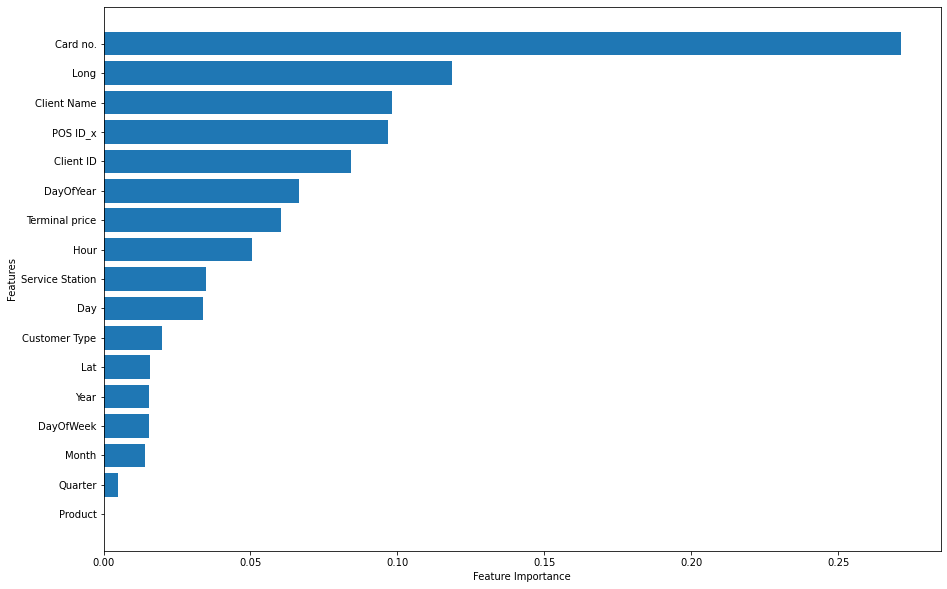

In [126]:
plot_features(X_train.columns,model.feature_importances_)